<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/PyTorch/%EB%94%A5%EB%9F%AC%EB%8B%9D%20%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98%20%EA%B5%90%EA%B3%BC%EC%84%9C/6%EC%9E%A5_%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [3]:
!git clone https://github.com/gilbutITbook/080289.git

Cloning into '080289'...
remote: Enumerating objects: 2273, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 2273 (delta 3), reused 25 (delta 2), pack-reused 2246
Receiving objects: 100% (2273/2273), 330.27 MiB | 17.42 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Checking out files: 100% (2590/2590), done.


# LeNet-5

라이브러리 불러오기

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

데이터셋 전처리

In [2]:
class ImageTransform():

  def __init__(self, resize, mean, std):

    self.data_transform = {
        'train':transforms.Compose([
            transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)]),
        'val':transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }

  def __call__(self, img, phase):

    return self.data_transform[phase](img)

데이터셋 분할

In [4]:
cat_directory = r'/content/080289/chap06/data/dogs-vs-cats/Cat/'
dog_directory = r'/content/080289/chap06/data/dogs-vs-cats/Dog/'

In [5]:
cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]

correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

In [6]:
random.seed(2022)
random.shuffle(correct_images_filepaths)

In [7]:
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]

print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


이미지 확인

In [8]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):

    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))

    for i, image_filepath in enumerate(images_filepaths):

        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
        
    plt.tight_layout()
    plt.show()

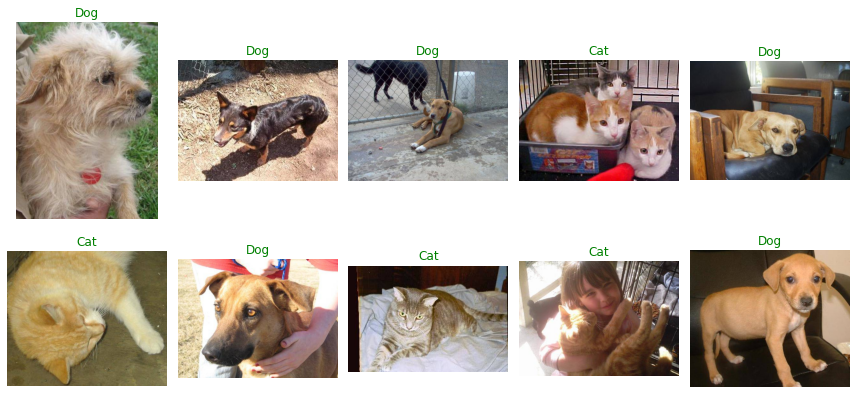

In [9]:
display_image_grid(test_images_filepaths)

데이터셋 클래스 정의

In [13]:
class DogvsCatDataset(Dataset):

    def __init__(self, file_list, transform=None, phase='train'):  

        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):

        return len(self.file_list)
    
    def __getitem__(self, idx):

        img_path = self.file_list[idx]
        img = Image.open(img_path)        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]

        if label == 'dog':

            label = 1

        elif label == 'cat':

            label = 0
            
        return img_transformed, label

변수 정의

In [14]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

데이터셋 정의

In [15]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0

print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


데이터로더 정의

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)

print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 1])


모델 정의

In [20]:
class LeNet(nn.Module):

    def __init__(self):

        super(LeNet, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) 
        self.relu1 = nn.ReLU() 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) 
        self.relu2 = nn.ReLU() 
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)         
        self.fc1 = nn.Linear(32*53*53, 512) 
        self.relu5 = nn.ReLU()         
        self.fc2 = nn.Linear(512, 2) 
        self.output = nn.Softmax(dim=1)        
    
    def forward(self, x):

        out = self.cnn1(x) 
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out) 
        out = self.relu2(out) 
        out = self.maxpool2(out) 
        out = out.view(out.size(0), -1) 
        out = self.fc1(out) 
        out = self.fc2(out)                    
        out = self.output(out)
        
        return out

In [21]:
model = LeNet().to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


모델 구조 확인

In [22]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

파라미터 수 확인

In [23]:
def count_parameters(model):
  
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


옵티마이저와 손실 함수 정의

In [24]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

파라미터와 손실 함수 cpu에 할당

In [25]:
model = model.to(device)
criterion = criterion.to(device)

학습 함수 정의

In [26]:
import time

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    

    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):

        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:   

            if phase == 'train':

                model.train()

            else:

                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':

                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:

                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model

In [27]:
num_epoch = 20
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/20
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6971 Acc: 0.4775


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6903 Acc: 0.5000
Epoch 2/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6968 Acc: 0.5100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7084 Acc: 0.4457
Epoch 3/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6942 Acc: 0.5375


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6942 Acc: 0.5978
Epoch 4/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5400


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6908 Acc: 0.5543
Epoch 5/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6736 Acc: 0.5925


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6972 Acc: 0.5326
Epoch 6/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6742 Acc: 0.5800


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6860 Acc: 0.5870
Epoch 7/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6665 Acc: 0.6050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6962 Acc: 0.5217
Epoch 8/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6623 Acc: 0.6050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6900 Acc: 0.5870
Epoch 9/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6589 Acc: 0.6175


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6974 Acc: 0.5326
Epoch 10/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6508 Acc: 0.6275


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6947 Acc: 0.5435
Epoch 11/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6494 Acc: 0.6350


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6798 Acc: 0.5978
Epoch 12/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6463 Acc: 0.6425


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7001 Acc: 0.5217
Epoch 13/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6475 Acc: 0.6225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6698 Acc: 0.5978
Epoch 14/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6472 Acc: 0.6250


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6746 Acc: 0.5870
Epoch 15/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6364 Acc: 0.6450


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6813 Acc: 0.5761
Epoch 16/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6351 Acc: 0.6700


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6544 Acc: 0.6413
Epoch 17/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6286 Acc: 0.6650


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6754 Acc: 0.5870
Epoch 18/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6257 Acc: 0.6825


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6560 Acc: 0.6196
Epoch 19/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6292 Acc: 0.6600


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6719 Acc: 0.5543
Epoch 20/20
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6385 Acc: 0.6500


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6453 Acc: 0.6739
Training complete in 0m 52s
Best val Acc: 0.673913


모델 테스트 함수

In [28]:
import pandas as pd

id_list = []
pred_list = []
_id=0

with torch.no_grad():

    for test_path in tqdm(test_images_filepaths):
      
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('LesNet.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
res.head(10)

,id,label
0,110,0.643774
1,117,0.521329
2,123,0.685779
3,126,0.590119
4,141,0.415617
5,191,0.647672
6,230,0.634383
7,233,0.720316
8,240,0.724436
9,77,0.607248


테스트 데이터셋 예측 이미지 출력

In [30]:
class_ = classes = {0:'cat', 1:'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):

    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))

    for i, image_filepath in enumerate(images_filepaths):

        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]

        if label > 0.5:

            label = 1

        else:

            label = 0

        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
        
    plt.tight_layout()
    plt.show()

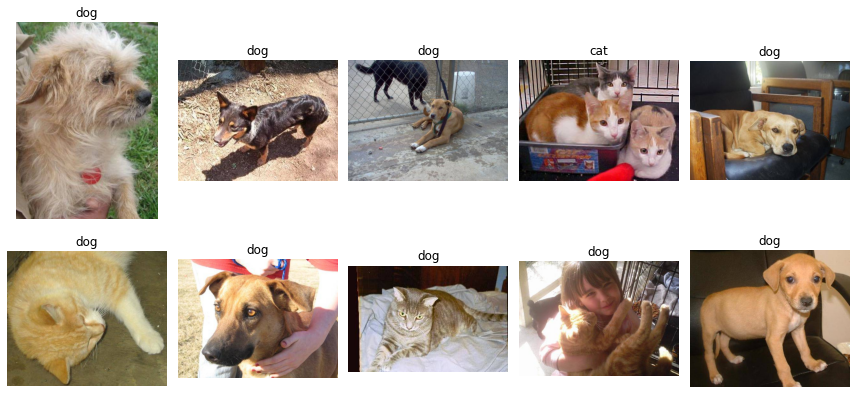

In [31]:
display_image_grid(test_images_filepaths) 